# AIN 214 - PA4 - 2023
## Building kNN and Logistic Regression Classifiers


# THE STUDENT INFO
## Student Name: Zaina Abushaban    


# Dataset: We will use the Breast Cancer Wisconsin (Diagnostic) Dataset available on Kaggle for the assignment. 
https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data

## 1. Data Preprocessing

In this section, you will:
- Import necessary libraries
- Load the dataset
- Handle missing values and outliers
- Convert non-numeric values to numeric 
- Perform data normalization

In [308]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [309]:
# Loading the dataset:
path_to_dataset = 'data.csv'
df = pd.read_csv(path_to_dataset)

Handling missing values


In [310]:
df.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

We notice the only nulls are in the last column, which is just empty, so we drop it and check:
Also ID column in useless for us so we can just drop it:

In [311]:
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
#Dropping the ID column because it's not relevant:
df.drop(df.columns[0], axis=1, inplace=True)

null_sum = df.isnull().sum().sum()

print("Sum of all null values:")
print(null_sum)

Sum of all null values:
0


In [312]:
#Checkpoint Function
def checkpoint(dataframe, filename):
    dataframe.to_csv(f"{filename}.csv", index=False)
    print(f"Checkpoint '{filename}' created.")
    df= dataframe.copy(deep=True)

Before handling the outliers, we should turn the non-numeric values into numeric values so we can work with them and make our regression classification models.

In [313]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
data = df[['diagnosis']]
encoded_data = encoder.fit_transform(data)
df['diagnosis']=encoded_data
checkpoint(df,"all_numerical")


Checkpoint 'all_numerical' created.


Now 1 represents M, 0 Represents B.

Normalizing :

In [314]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df)
df[df.columns] = scaled_df


Handling outliers


In [315]:
for col in df:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_condition_col = (df[col] < lower_bound) | (df[col] > upper_bound)
    
    #For all outliers, impute with the median of the column 
    col_median = df[~outliers_condition_col][col].median()
    df.loc[outliers_condition_col, col] = col_median

#Making the checkpoint:
checkpoint(df, "no_outliers")


Checkpoint 'no_outliers' created.


## 2. Data Visualization

Visualize the data to understand it better:
- Correlation heatmap
- Distribution plots for at least 3 features


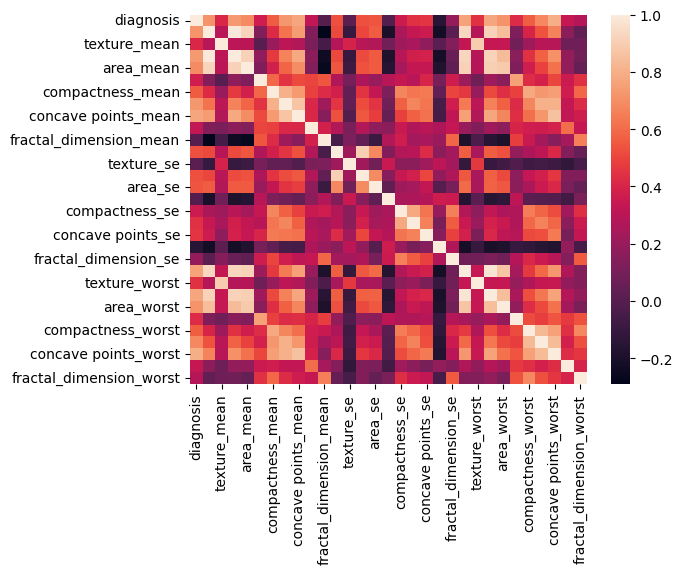

In [316]:

heatmap = sns.heatmap(df.corr(), cbar=True)  

plt.show()



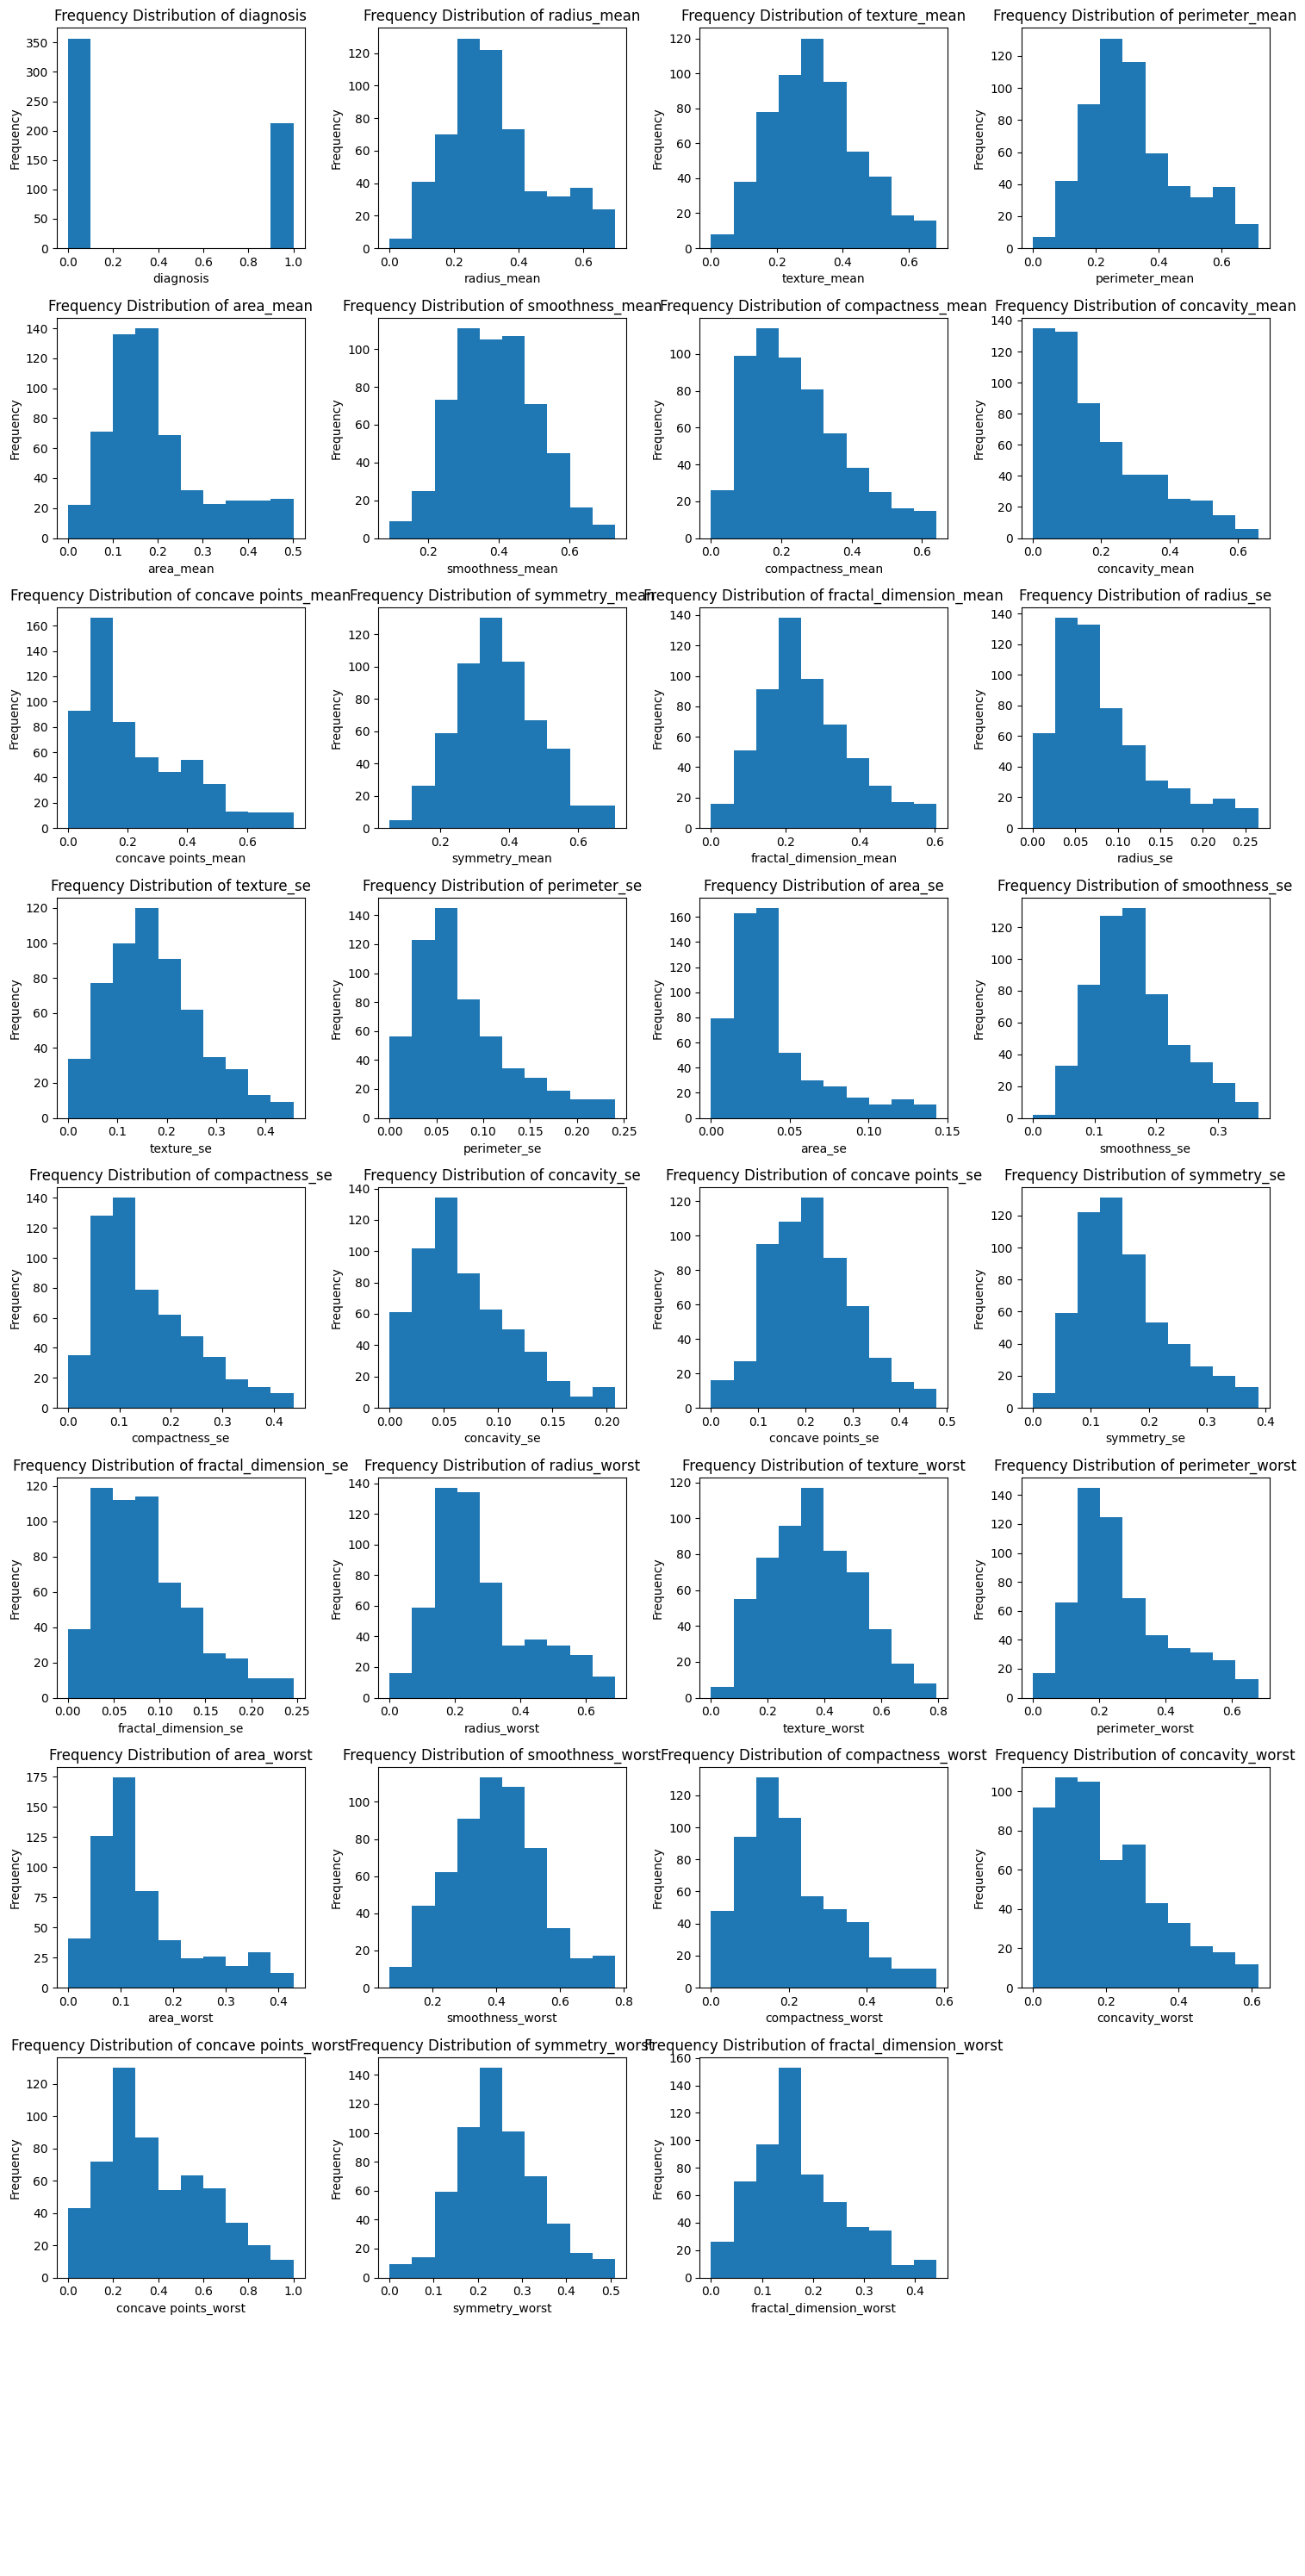

In [317]:
import matplotlib.pyplot as plt

num_features = len(df.columns)
num_cols = 4
num_rows = 9

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 30))  
axes = axes.flatten()

for i, column in enumerate(df.columns):
    axes[i].hist(df[column], bins=10) 
    axes[i].set_title(f'Frequency Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
for j in range(num_features, num_cols * num_rows):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## 3. Data Splitting

Manually split the data into training and testing sets in a 70:30 ratio:
- Shuffle and split the data
- Avoid using predefined functions like train_test_split for this task


In [318]:
import random
def split_df(dataframe, seed=None):
    if seed is not None:
        random.seed(seed)
    data_rows = dataframe.values.tolist()

    random.shuffle(data_rows)

    train_val = 0.7
    split = int(len(data_rows) * train_val)

    train_data = data_rows[:split]
    test_data = data_rows[split:]

    train_df = pd.DataFrame(train_data, columns=dataframe.columns)
    test_df = pd.DataFrame(test_data, columns=dataframe.columns)

    return train_df, test_df
train_df, test_df = split_df(df, seed=23)

## 4. Model Building

### 4.1. kNN Classifier

- Build and train the kNN model
- Choose the optimal k value using Minkowski distance with at least two different values for p 

In [319]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

max_accuracy = 0
best_k = 1
best_p = 0
expected_vals_knn = []

for k in range(1, 30):
    target = "diagnosis"
    X_train = train_df.drop(columns=[target])
    y_train = train_df[target]

    X_test = test_df.drop(columns=[target])
    y_test = test_df[target]

    # Calculate accuracy for Euclidean distance
    neigh_euclidean = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=2)
    neigh_euclidean.fit(X_train, y_train)
    predictions_euclidean = neigh_euclidean.predict(X_test)
    accuracy_euclidean = accuracy_score(y_test, predictions_euclidean)

    # Calculate accuracy for Manhattan distance
    neigh_manhattan = KNeighborsClassifier(n_neighbors=k, metric='minkowski', p=1)
    neigh_manhattan.fit(X_train, y_train)
    predictions_manhattan = neigh_manhattan.predict(X_test)
    accuracy_manhattan = accuracy_score(y_test, predictions_manhattan)

    # Update best_k and best_p based on the higher accuracy obtained
    if accuracy_manhattan > max_accuracy:
        max_accuracy = accuracy_manhattan
        best_k = k
        best_p = 1
        expected_vals_knn = predictions_manhattan

    if accuracy_euclidean > max_accuracy:
        max_accuracy = accuracy_euclidean
        best_k = k
        best_p = 2
        expected_vals_knn = predictions_euclidean

print("The maximum accuracy is:", max_accuracy)
print("The K to achieve this accuracy is:", best_k)
print("The p to achieve this accuracy is:", best_p)



The maximum accuracy is: 0.9707602339181286
The K to achieve this accuracy is: 9
The p to achieve this accuracy is: 2


### 4.2. Logistic Regression

- Build and train the Logistic Regression model

In [320]:
from sklearn.linear_model import LogisticRegression

reg = LogisticRegression(random_state=23).fit(X_train, y_train)
#We set the random state to a specific number so we get the same values across all runs

predicted_labels = reg.predict(X_test)
predicted_labels

array([0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
       1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1.,
       0.])

## 5. Model Evaluation

### 5.1. Confusion Matrix

Analysis of the confusion matrices for both models:
- Plot and interpret the confusion matrices
- Display accuracy, precision, recall, and F1-score for both models

For KNN Classifier:

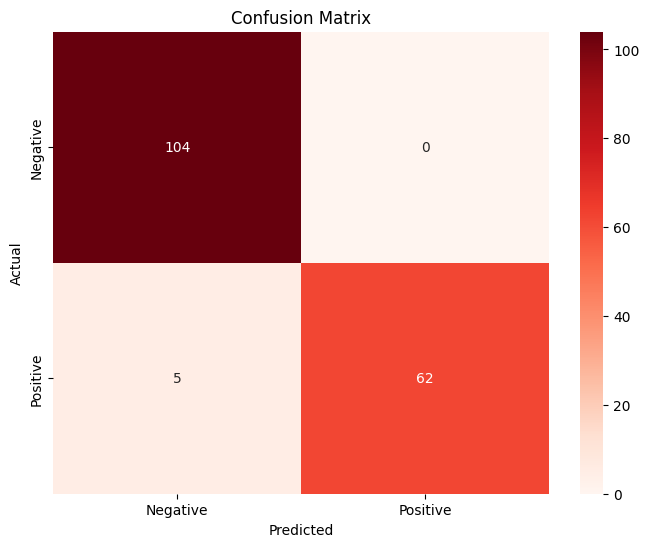

Accuracy:  0.9707602339181286
Precision:  1.0
Recall:  0.9253731343283582
F1 Score:  0.9612403100775194


In [321]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns
def conMat(actual, expected):
    conf_matrix_knn = confusion_matrix(actual, expected)

    #We can visualize it like so:
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix_knn, annot=True, cmap='Reds', fmt='d', 
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = accuracy_score(actual, expected)
    precision = precision_score(actual, expected)
    recall = recall_score(actual, expected)
    f1 = f1_score(actual, expected)

    print("Accuracy: ",accuracy)
    print("Precision: ", precision)
    print("Recall: ",recall)
    print("F1 Score: ",f1)
conMat(y_test, expected_vals_knn)

For logistic regression:

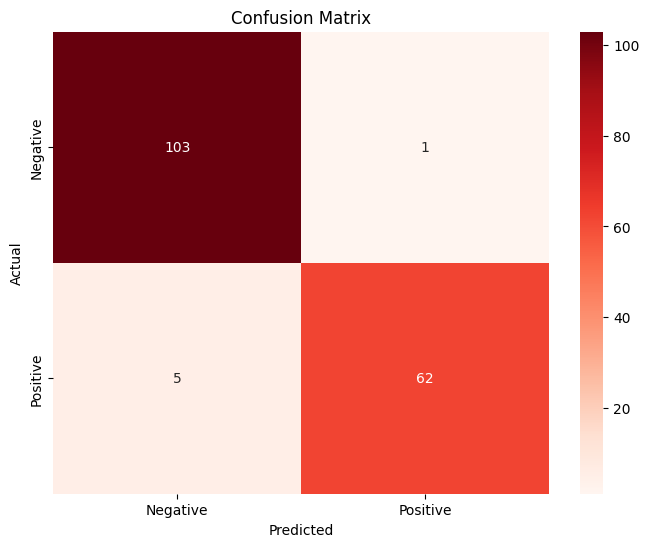

Accuracy:  0.9649122807017544
Precision:  0.9841269841269841
Recall:  0.9253731343283582
F1 Score:  0.9538461538461538


In [322]:
conMat(y_test, predicted_labels)

### 5.2. Precision-Recall Curves

Evaluate the Precision-Recall curves for both models:
- Plot and analyze the curves

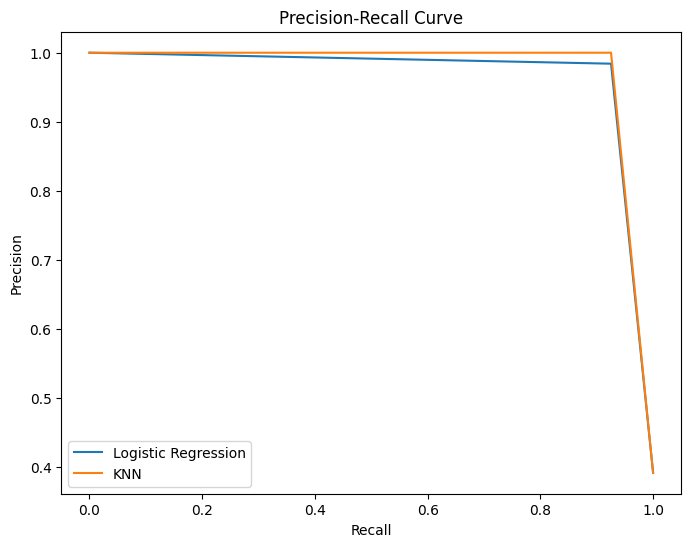

In [323]:
from sklearn.metrics import precision_recall_curve
precision_logreg, recall_logreg, _ = precision_recall_curve(y_test, predicted_labels)
precision_knn, recall_knn, _ = precision_recall_curve(y_test, expected_vals_knn)

plt.figure(figsize=(8, 6))
plt.plot(recall_logreg, precision_logreg, label='Logistic Regression')
plt.plot(recall_knn, precision_knn, label='KNN')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

This generally means we have a good model, since we want the most accurate model, which means we aim for the top right corner.
When the recall values grow, the precision values fall and vice versa.
We notice that we can have a precision of 0.9 while having a 0.9 recall which is relatively an accurate model, because we aren't sacrificing recall for the precision or the other way around.
Even though both models are accurate, KNN Regression seems to be closer to the corner (perfection) so we can say it is a more accurate model.

### 5.3. Choose an appropriate metric to evaulate the models. Compare the models and discuss why you chose the metric.

In [324]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

auc_logreg = auc(recall_logreg, precision_logreg)
auc_knn = auc(recall_knn, precision_knn)

print("AUC for Logistic Regression" , auc_logreg)
print("AUC for KNN Regression" ,auc_knn)

AUC for Logistic Regression 0.9693699422686068
AUC for KNN Regression 0.9773064502051148


I chose AUC because it tells us about the underlying model without depending on the threshold value.
Here we notice KNN regression has a higher AUC, which is further proved in the previous part, making it a more accurate model.